# Capstone Project - The Battle of the Neighborhoods (week 2)

## Where to buy a flat for Airbnb in Budapest?

# Applied Data Science Capstone by IBM/Coursera

![alt text](https://www.nationalgeographic.com/content/dam/travel/Guide-Pages/europe/budapest-travel.adapt.1900.1.jpg "Budapest")

## Introduction: Business Problem¶

### Background

Airbnb, the worldwide online marketplace for hospitality services, is getting more and more popular. In the Hungarian capital Budapest - where I currently live - the number of overnight stays reached almost 1.5 million in 2017, 35% more than 2016, according to a 2018 report by Colliers. (Colliers, 2018) In 2017 there were 42.5 thousand Airbnb accommodations in the city, almost as many as in hotels. (Jancsik, Michalkó, Csernyik, 2018)
A lot of investors buy flats specifically to rent them as Airbnb accommodations. The rent for one flat is between 700 and 1000 USD per month. (Jancsik, Michalkó, Csernyik, 2018) However, it is very important that the flat has an excellent location that is attractive for tourists. In Budapest, the Airbnb letting market is mostly concentrated within the downtown area – District V, VI and VII – followed by districts VIII, IX, XIII and I. The top 3 neighbourhoods account for 69% of the total Airbnb supply in Budapest. (Colliers, 2018)

### Problem

Let's imagine that an investor wants to buy a flat to rent it as Airbnb. What is the right location for such a flat? It should be in one of those neighborhoods where there are lots of tourist attractions, bars, restaurants and other venues that are attractive for tourists, because if it is too far away from these places of interest, they will not rent it. However, housing prices should also be considered. In the inner city, average housing prices are much higher, and the investment might not pay off.
The goal of this project is to find the best neighborhoods in Budapest to buy a flat for Airbnb based on the nearby venues of interest and housing prices.

### Interest

The results can be useful for any investor who wants to buy a flat in Budapest to rent as an Airbnb accommodation. The Budapest Airbnb market is driven by professional operators who own multiple accommodations. Around 65% of listings are offered by hosts that have at least two listings, which is much higher than the 40-50% average multi- listers ratio across most other European cities. Around 31% of listings are offered by a host that offers 3-10 accommodations while in the 10+ category it is 19.5%. (Colliers, 2018) However, there are also small investors who rent only one apartment.

## Data

To determine which neighborhoods are the most suitable for Airbnb flats, I will take two main factors into consideration: places of interest in the neighborhood and average housing prices.

First let's import some necessary libraries.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

### Neighborhood candidates with latitudes and longitudes¶

First, we need the data of the potential neighborhoods. Budapest has 23 districts numbered from I to XXIII. According to the Colliers report, the Airbnb room demand is concentrated within the downtown area and is insignificant in the rest of the districts, so I work only with districts I, V, VI, VII, VIII, IX and XIII. In these 7 districts there are 17 neighborhoods. I got their data from Wikipedia (https://hu.wikipedia.org/wiki/Budapest_v%C3%A1rosr%C3%A9szeinek_list%C3%A1ja), including their coordinates, because the Python Geocoder package was very unreliable. The latitudes and longitudes are all on the separate Wikipedia pages of the neighborhoods, so it could not be scraped, however, I already had the necessary data in csv format, so I used that.

I uploaded the csv file to my Capstone Project in IBM Watson Studio, and here I insert it into a Pandas dataframe.

In [2]:
# The code was removed by Watson Studio for sharing.

,District,Neighborhood,Latitude,Longitude
0,I.,Tabán,47.491667,19.040833
1,I.,Vár,47.501667,19.033333
2,I.,Gellérthegy,47.486667,19.045556
3,I.,Krisztinaváros,47.496806,19.031933
4,V.,Belváros,47.492397,19.053314
5,V.,Lipótváros,47.502500,19.050833
6,VI.,Terézváros,47.509667,19.069833
7,VII.,Erzsébetváros,47.500556,19.068725
8,VIII.,Corvin-negyed,47.486991,19.073339
9,VIII.,Magdolnanegyed,47.491500,19.084200


Let's explore the neighborhood candidates by creating a map with the neighborhood candidates superimposed on top.

In [3]:
# Using geopy library to get the latitude and longitude values of Budapest.

address = 'Budapest, Hungary'

geolocator = Nominatim(user_agent="budapest_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Budapest are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Budapest are 47.4983815, 19.0404707.


In [4]:
import folium

# create map of Budapest using latitude and longitude values
map_budapest = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, district, neighborhood in zip(latlong['Latitude'], latlong['Longitude'], latlong['District'], latlong['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_budapest)  
    
map_budapest

### Housing prices

The second group of data we need is the average housing price in each potential borough. I found the average price in Hungarian Forint / m2 in each neighborhood on the website https://www.ingatlannet.hu/statisztika/Budapest. Again, the necessary values were on separate pages, so I had to write them manually into a csv file, which I uploaded to my project on IBM Watson Studio and inserted into the code as a Pandas dataframe.

In [5]:
body = client_63f6640549c449dbb041cd4650f58c69.get_object(Bucket='capstoneproject-donotdelete-pr-ciqgfgwrq5usre',Key='bphousing.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

housing = pd.read_csv(body)
housing

,District,Neighborhood,Average price HUF/m2
0,I.,Tabán,970833
1,I.,Vár,916666
2,I.,Gellérthegy,1406771
3,I.,Krisztinaváros,1029796
4,V.,Belváros,2331877
5,V.,Lipótváros,1196756
6,VI.,Terézváros,988124
7,VII.,Erzsébetváros,846815
8,VIII.,Corvin-negyed,695030
9,VIII.,Magdolnanegyed,580193


### Foursquare

Finally, our last data source is the Foursquare API, which can give us the venues of interest in each candidate neighborhood. Let's explore the downtown of Budapest!

Defining Foursquare credentials, version and limit:

In [6]:
CLIENT_ID = 'JB4FCOFLGRUUWKWZ1PCZFHS1J241XYSQMXONTUXSNFYGU4FC'
CLIENT_SECRET = '4TNODEVIX4Z3D20FUL1UGC4H3S24OG053PNI2CI0YXBCZEYQ' 
VERSION = '20180605'
LIMIT = 100

Let's create a function to get the top 100 venues the in each neighborhood within a radius of 500 meters.

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function on each neighborhood and create a new dataframe called budapest_venues

In [8]:
budapest_venues = getNearbyVenues(names=latlong['Neighborhood'],
                                   latitudes=latlong['Latitude'],
                                   longitudes=latlong['Longitude']
                                  )

Tabán
Vár
Gellérthegy
Krisztinaváros
Belváros
Lipótváros
Terézváros
Erzsébetváros
Corvin-negyed
Magdolnanegyed
Orczynegyed
Palotanegyed
Tisztviselőtelep
Ferencváros
Angyalföld
Újlipótváros
Vizafogó


In [9]:
budapest_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tabán,47.491667,19.040833,Oxygen Wellness Naphegy,47.491025,19.037900,Gym / Fitness Center
1,Tabán,47.491667,19.040833,Asztalka,47.492193,19.044231,Dessert Shop
2,Tabán,47.491667,19.040833,Filozófusok kertje,47.489381,19.039051,Sculpture Garden
3,Tabán,47.491667,19.040833,Várkert,47.493569,19.041017,Park
4,Tabán,47.491667,19.040833,Picnic,47.491330,19.044697,Café


Check how many venues were returned for each neighbourhood:

In [10]:
budapest_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Angyalföld,95,95,95,95,95,95
Belváros,100,100,100,100,100,100
Corvin-negyed,100,100,100,100,100,100
Erzsébetváros,100,100,100,100,100,100
Ferencváros,23,23,23,23,23,23
Gellérthegy,19,19,19,19,19,19
Krisztinaváros,43,43,43,43,43,43
Lipótváros,100,100,100,100,100,100
Magdolnanegyed,12,12,12,12,12,12


As we are going to use k-means clustering, it will be useful to use one hot encoding for the venue categories:

In [11]:
# one hot encoding
budapest_onehot = pd.get_dummies(budapest_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
budapest_onehot['Neighborhood'] = budapest_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [budapest_onehot.columns[-1]] + list(budapest_onehot.columns[:-1])
budapest_onehot = budapest_onehot[fixed_columns]

budapest_onehot.head()

,Neighborhood,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Stop,Butcher,Café,Camera Store,Casino,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health & Beauty Service,Health Food Store,Hill,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Kids Store,Laser Tag,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pub,Radio Station,Record Shop,Restaurant,Road,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Souvenir Shop,Spa,Speakeasy,Sporting Goods Shop,Steakhouse,Strip Club,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Park,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Tabán,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Tabán,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Tabán,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Group rows by neighborhood and take the mean of the frequency of occurrence of each category

In [12]:
budapest_grouped = budapest_onehot.groupby('Neighborhood').mean().reset_index()
budapest_grouped

,Neighborhood,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Stop,Butcher,Café,Camera Store,Casino,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health & Beauty Service,Health Food Store,Hill,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Kids Store,Laser Tag,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pub,Radio Station,Record Shop,Restaurant,Road,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Souvenir Shop,Spa,Speakeasy,Sporting Goods Shop,Steakhouse,Strip Club,Student Center,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Park,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Angyalföld,0.010526,0.021053,0.000000,0.000000,0.010526,0.000000,0.010526,0.000000,0.031579,0.021053,0.000000,0.00,0.000000,0.000000,0.000000,0.010526,0.000000,0.010526,0.00,0.0000,0.000000,0.000000,0.021053,0.000000,0.00,0.010526,0.000000,0.021053,0.010526,0.010526,0.021053,0.000000,0.00,0.031579,0.000000,0.00,0.010526,0.052632,0.00,0.021053,0.00,0.00,0.010526,0.00,0.000000,0.042105,0.00,0.0000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.010526,0.0000,0.021053,0.00,0.000000,0.000000,0.000000,0.031579,0.00,0.010526,0.010526,0.00,0.000000,0.00,0.000000,0.010526,0.000000,0.000000,0.010526,0.010526,0.010526,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.021053,0.021053,0.010526,0.000000,0.00,0.010526,0.000000,0.000000,0.000000,0.000000,0.000000,0.010526,0.00,0.000000,0.000000,0.010526,0.010526,0.010526,0.000000,0.000000,0.00,0.00,0.021053,0.00,0.000000,0.00,0.00,0.010526,0.010526,0.010526,0.000000,0.000000,0.010526,0.000000,0.000000,0.000000,0.010526,0.010526,0.010526,0.00,0.000000,0.000000,0.00,0.010526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010526,0.000000,0.010526,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.010526,0.

Let's see the top 5 most common venues in each neighborhood!

In [13]:
num_top_venues = 5

for hood in budapest_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = budapest_grouped[budapest_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Angyalföld----
               venue  freq
0     Clothing Store  0.05
1     Cosmetics Shop  0.04
2      Women's Store  0.03
3  Electronics Store  0.03
4             Bakery  0.03


----Belváros----
                  venue  freq
0           Coffee Shop  0.06
1  Hungarian Restaurant  0.06
2                 Hotel  0.06
3    Italian Restaurant  0.05
4                  Café  0.04


----Corvin-negyed----
            venue  freq
0           Hotel  0.06
1  Clothing Store  0.05
2          Bakery  0.04
3    Dessert Shop  0.04
4        Wine Bar  0.03


----Erzsébetváros----
                  venue  freq
0                 Hotel  0.09
1           Coffee Shop  0.08
2            Restaurant  0.06
3                   Bar  0.05
4  Hungarian Restaurant  0.05


----Ferencváros----
                  venue  freq
0           Music Venue  0.22
1  Fast Food Restaurant  0.09
2     Mobile Phone Shop  0.04
3         Historic Site  0.04
4             Pet Store  0.04


----Gellérthegy----
               venue  fr

Now let's put this data into a pandas dataframe. Create a function to sort the venues in descending order:

In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new dataframe and display the top 10 venues for each neighborhood:

In [15]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = budapest_grouped['Neighborhood']

for ind in np.arange(budapest_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(budapest_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Angyalföld,Clothing Store,Cosmetics Shop,Electronics Store,Bakery,Pharmacy,Chinese Restaurant,Women's Store,Pub,Diner,Coffee Shop
1,Belváros,Coffee Shop,Hotel,Hungarian Restaurant,Italian Restaurant,Plaza,Café,Restaurant,Eastern European Restaurant,Dessert Shop,Theater
2,Corvin-negyed,Hotel,Clothing Store,Bakery,Dessert Shop,Plaza,Beer Bar,Electronics Store,Italian Restaurant,Wine Bar,Coffee Shop
3,Erzsébetváros,Hotel,Coffee Shop,Restaurant,Bar,Hungarian Restaurant,Indian Restaurant,Beer Bar,Bistro,Burger Joint,Bakery
4,Ferencváros,Music Venue,Fast Food Restaurant,Pet Store,Train Station,Furniture / Home Store,Café,Jazz Club,Mobile Phone Shop,Cosmetics Shop,Gym / Fitness Center
5,Gellérthegy,Playground,Outdoor Sculpture,Grocery Store,Ice Cream Shop,Trail,Scenic Lookout,Eastern European Restaurant,Beer Garden,Bus Stop,Dog Run
6,Krisztinaváros,Café,Bakery,Plaza,Playground,Grocery Store,Restaurant,Coffee Shop,Bistro,Cupcake Shop,Sculpture Garden
7,Lipótváros,Restaurant,Italian Restaurant,Coffee Shop,Hotel,Hungarian Restaurant,Bar,Bistro,Ice Cream Shop,Wine Bar,Dessert Shop
8,Magdolnanegyed,Hotel,Plaza,Coffee Shop,Supermarket,Burger Joint,Gym / Fitness Center,Food & Drink Shop,Bakery,Café,Miscellaneous Shop
9,Orczynegyed,Park,Flower Shop,Track,Science Museum,Botanical Garden,Garden,Coffee Shop,Donut Shop,Gym,Theater


We know what the top ten venue categories are in each neighborhood. We can use this information for clustering in the next section.

Now we have all the data we need to find out which Budapest neighborhood wins the battle of the neighborhoods for being the best Airbnb location. To be continued!

## Methodology

How can we use our data to determine which neighborhood is the best location for an Airbnb flat?  
It would help us to divide the neighborhoods into clusters based on the types of venues.  
Let's run k-means clustering to cluster the neighborhoods into four categories:

In [16]:
# set number of clusters
kclusters = 4

budapest_grouped_clustering = budapest_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(budapest_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 2, 3, 1, 1, 1, 1], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood:

In [17]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

budapest_merged = latlong

# merge budapest_grouped with latlong to add latitude/longitude for each neighborhood
budapest_merged = budapest_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

budapest_merged

,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I.,Tabán,47.491667,19.040833,1,Park,Plaza,History Museum,Hungarian Restaurant,Scenic Lookout,Dessert Shop,Sculpture Garden,Outdoor Sculpture,Building,Lounge
1,I.,Vár,47.501667,19.033333,1,Café,Hungarian Restaurant,Hotel,Restaurant,Historic Site,Park,Pub,Plaza,Coffee Shop,Bar
2,I.,Gellérthegy,47.486667,19.045556,3,Playground,Outdoor Sculpture,Grocery Store,Ice Cream Shop,Trail,Scenic Lookout,Eastern European Restaurant,Beer Garden,Bus Stop,Dog Run
3,I.,Krisztinaváros,47.496806,19.031933,1,Café,Bakery,Plaza,Playground,Grocery Store,Restaurant,Coffee Shop,Bistro,Cupcake Shop,Sculpture Garden
4,V.,Belváros,47.492397,19.053314,1,Coffee Shop,Hotel,Hungarian Restaurant,Italian Restaurant,Plaza,Café,Restaurant,Eastern European Restaurant,Dessert Shop,Theater
5,V.,Lipótváros,47.502500,19.050833,1,Restaurant,Italian Restaurant,Coffee Shop,Hotel,Hungarian Restaurant,Bar,Bistro,Ice Cream Shop,Wine Bar,Dessert Shop
6,VI.,Terézváros,47.509667,19.069833,1,Coffee Shop,Bar,Hotel,Indian Restaurant,Park,Ice Cream Shop,Record Shop,Pub,Plaza,Pizza Place
7,VII.,Erzsébetváros,47.500556,19.068725,1,Hotel,Coffee Shop,Restaurant,Bar,Hungarian Restaurant,Indian Restaurant,Beer Bar,Bistro,Burger Joint,Bakery
8,VIII.,Corvin-negyed,47.486991,19.073339,1,Hotel,Clothing Store,Bakery,Dessert Shop,Plaza,Beer Bar,Electronics Store,Italian Restaurant,Wine Bar,Coffee Shop
9,VIII.,Magdolnanegyed,47.491500,19.084200,1,Hotel,Plaza,Coffee Shop,Supermarket,Burger Joint,Gym / Fitness Center,Food & Drink Shop,Bakery,Café,Miscellaneous Shop


Let's visualize our clusters on a map:

In [18]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(budapest_merged['Latitude'], budapest_merged['Longitude'], budapest_merged['Neighborhood'], budapest_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's examine our clusters more closely!

Cluster 1

In [19]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 0, budapest_merged.columns[[1] + list(range(5, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Tisztviselőtelep,Park,Hotel,Bus Stop,Grocery Store,Optical Shop,Nightclub,Museum,Eastern European Restaurant,Restaurant,Coffee Shop
16,Vizafogó,Bus Stop,Restaurant,Grocery Store,Athletics & Sports,Food Court,Dance Studio,Café,Chinese Restaurant,Coffee Shop,Convenience Store


Cluster 2

In [20]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 1, budapest_merged.columns[[1] + list(range(5, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Tabán,Park,Plaza,History Museum,Hungarian Restaurant,Scenic Lookout,Dessert Shop,Sculpture Garden,Outdoor Sculpture,Building,Lounge
1,Vár,Café,Hungarian Restaurant,Hotel,Restaurant,Historic Site,Park,Pub,Plaza,Coffee Shop,Bar
3,Krisztinaváros,Café,Bakery,Plaza,Playground,Grocery Store,Restaurant,Coffee Shop,Bistro,Cupcake Shop,Sculpture Garden
4,Belváros,Coffee Shop,Hotel,Hungarian Restaurant,Italian Restaurant,Plaza,Café,Restaurant,Eastern European Restaurant,Dessert Shop,Theater
5,Lipótváros,Restaurant,Italian Restaurant,Coffee Shop,Hotel,Hungarian Restaurant,Bar,Bistro,Ice Cream Shop,Wine Bar,Dessert Shop
6,Terézváros,Coffee Shop,Bar,Hotel,Indian Restaurant,Park,Ice Cream Shop,Record Shop,Pub,Plaza,Pizza Place
7,Erzsébetváros,Hotel,Coffee Shop,Restaurant,Bar,Hungarian Restaurant,Indian Restaurant,Beer Bar,Bistro,Burger Joint,Bakery
8,Corvin-negyed,Hotel,Clothing Store,Bakery,Dessert Shop,Plaza,Beer Bar,Electronics Store,Italian Restaurant,Wine Bar,Coffee Shop
9,Magdolnanegyed,Hotel,Plaza,Coffee Shop,Supermarket,Burger Joint,Gym / Fitness Center,Food & Drink Shop,Bakery,Café,Miscellaneous Shop
10,Orczynegyed,Park,Flower Shop,Track,Science Museum,Botanical Garden,Garden,Coffee Shop,Donut Shop,Gym,Theater


Cluster 3

In [21]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 2, budapest_merged.columns[[1] + list(range(5, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Ferencváros,Music Venue,Fast Food Restaurant,Pet Store,Train Station,Furniture / Home Store,Café,Jazz Club,Mobile Phone Shop,Cosmetics Shop,Gym / Fitness Center


Cluster 4

In [22]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 3, budapest_merged.columns[[1] + list(range(5, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Gellérthegy,Playground,Outdoor Sculpture,Grocery Store,Ice Cream Shop,Trail,Scenic Lookout,Eastern European Restaurant,Beer Garden,Bus Stop,Dog Run


We can see that most neighborhoods belong to the second cluster, which covers the inner city of Budapest. The most common venues here are cafés, hotels, restaurant - those places tourists are usually interested in. This cluster seems like a good place to rent an Airbnb. However, there are a many neighborhoods in this cluster. How do we choose the best ones?  
To get a clearer result, we can look at some other charasteristics of the neighborhoods: the number of "tourist venues" in the neighborhood and the average housing prices in the neighborhood.

### Categories of interest and housing prices

People who rent an Airbnb flat typically want to visit specific types of venues, and they are likely to choose an accommodation that is close to these places, in a vibrant neighborhood.  
Find out how many unique categories can be curated from all the returned venues:

In [23]:
print('There are {} unique categories.'.format(len(budapest_venues['Venue Category'].unique())))

There are 202 unique categories.


Let's see what they are:

In [24]:
#print out the list of categories
budapest_venues['Venue Category'].unique()

array(['Gym / Fitness Center', 'Dessert Shop', 'Sculpture Garden', 'Park',
       'Café', 'Pub', 'Historic Site', 'Lounge', 'Hungarian Restaurant',
       'Soccer Stadium', 'Outdoor Sculpture', 'Gift Shop', 'Bistro',
       'Plaza', 'History Museum', 'Scenic Lookout', 'Building',
       'Strip Club', 'Bus Stop', 'Italian Restaurant', 'Hotel',
       'Restaurant', 'Wine Bar', 'Bakery', 'Road', 'Ice Cream Shop',
       'Monument / Landmark', 'Coffee Shop', 'Motorcycle Shop',
       'Art Gallery', 'French Restaurant', 'Sushi Restaurant',
       'Beer Garden', 'Bar', 'Playground', 'Chocolate Shop',
       'Modern European Restaurant', 'Eastern European Restaurant',
       'Theater', 'Indie Theater', 'Beer Store', 'Mexican Restaurant',
       'Hookah Bar', 'Library', 'Gourmet Shop', 'BBQ Joint',
       'Souvenir Shop', 'Chinese Restaurant', 'Breakfast Spot',
       'Pizza Place', 'Dog Run', 'Performing Arts Venue',
       'Asian Restaurant', 'Belgian Restaurant', 'Mountain', 'Trail',
      

Which of these are attractive for tourists? They are most likely to visit restaurants, bars, different tourist attractions and other entertainment facilities. Let's list these spots, deleting those that tourists are not likely to visit, like stores or playgrounds.

In [25]:
categories_of_interest = ['Sculpture Garden', 'Café', 'Pub', 'Historic Site', 'Lounge', 'Hungarian Restaurant', 'Outdoor Sculpture', 'Bistro',
    'Plaza', 'History Museum', 'Wine Bar', 'Tourist Information Center', 'Italian Restaurant', 'Restaurant', 'Bakery', 'Ice Cream Shop',
    'Monument / Landmark', 'Coffee Shop', 'French Restaurant', 'Sushi Restaurant', 'Beer Garden', 'Bar', 'Modern European Restaurant',
    'Eastern European Restaurant', 'Theater', 'Indie Theater', 'Beer Store', 'Mexican Restaurant', 'Hookah Bar', 'BBQ Joint', 'Souvenir Shop',
    'Chinese Restaurant', 'Breakfast Spot', 'Diner', 'Performing Arts Venue', 'Asian Restaurant', 'Spa', 'Indie Movie Theater', 'Pizza Place',
    'Burger Joint', 'Cocktail Bar', 'Indian Restaurant', 'Gluten-free Restaurant', 'Vegetarian / Vegan Restaurant','Greek Restaurant',
    'Tea Room', 'Steakhouse', 'Thai Restaurant', 'Mediterranean Restaurant', 'Middle Eastern Restaurant', 'American Restaurant',
    'Sandwich Place', 'Cultural Center', 'Falafel Restaurant', 'Nightclub', 'Speakeasy', 'Creperie', 'Gastropub', 'Beer Bar',
    'Japanese Restaurant', 'Bagel Shop', 'Wine Shop', 'Juice Bar', 'Vietnamese Restaurant', 'Russian Restaurant', 'Noodle House', 'Taco Place',
    'Snack Place', 'Theme Park', 'German Restaurant', 'Jewish Restaurant', 'Concert Hall', 'Cuban Restaurant', 'Hot Dog Joint',
    'Fried Chicken Joint', 'Arcade', 'Fish & Chips Shop', 'Turkish Restaurant', 'Music Venue', 'Multiplex', 'Comedy Club',
    'Fast Food Restaurant', 'Gaming Cafe', 'Israeli Restaurant', 'Casino', 'Tapas Restaurant', 'Food Truck', 'Movie Theater', 'Laser Tag',
    'Jazz Club', 'Kebab Restaurant', 'Burrito Place', 'Comfort Food Restaurant']

We can filter the venues based on these categories of interest:

In [35]:
budapest_venues.columns = ['neighborhood', 'neigh_lat', 'neigh_long', 'venue', 'venue_lat', 'venue_long', 'venue_category']
tourist_venues = budapest_venues.query("venue_category in @categories_of_interest")
tourist_venues.head()

,neighborhood,neigh_lat,neigh_long,venue,venue_lat,venue_long,venue_category
2,Tabán,47.491667,19.040833,Filozófusok kertje,47.489381,19.039051,Sculpture Garden
4,Tabán,47.491667,19.040833,Picnic,47.491330,19.044697,Café
7,Tabán,47.491667,19.040833,Mr&Mrs Columbo Pub,47.492552,19.042136,Pub
8,Tabán,47.491667,19.040833,Várkert Bazár,47.494343,19.042807,Historic Site
9,Tabán,47.491667,19.040833,A Terasz,47.491089,19.037864,Lounge


Let's see which neighborhoods have the most venues that are attractive for tourists:

In [27]:
venue_counts = tourist_venues['neighborhood'].value_counts(dropna=True, sort=True)
df_venue_counts = pd.DataFrame(venue_counts)
df_venue_counts = df_venue_counts.reset_index()
df_venue_counts.columns = ['Neighborhood', 'Venue_count']
df_venue_counts

,Neighborhood,Venue_count
0,Lipótváros,79
1,Erzsébetváros,78
2,Vár,67
3,Belváros,64
4,Palotanegyed,59
5,Corvin-negyed,58
6,Angyalföld,45
7,Újlipótváros,40
8,Krisztinaváros,30
9,Terézváros,20


To make our work easier, make a dataframe that contains all our necessary information: the clusters, the number of interesting venues and average housing prices by merging our previous dataframes and dropping the unimportant columns.

In [28]:
merge = pd.merge(housing, budapest_merged, on='Neighborhood', how='inner')
merge.head()

,District_x,Neighborhood,Average price HUF/m2,District_y,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I.,Tabán,970833,I.,47.491667,19.040833,1,Park,Plaza,History Museum,Hungarian Restaurant,Scenic Lookout,Dessert Shop,Sculpture Garden,Outdoor Sculpture,Building,Lounge
1,I.,Vár,916666,I.,47.501667,19.033333,1,Café,Hungarian Restaurant,Hotel,Restaurant,Historic Site,Park,Pub,Plaza,Coffee Shop,Bar
2,I.,Gellérthegy,1406771,I.,47.486667,19.045556,3,Playground,Outdoor Sculpture,Grocery Store,Ice Cream Shop,Trail,Scenic Lookout,Eastern European Restaurant,Beer Garden,Bus Stop,Dog Run
3,I.,Krisztinaváros,1029796,I.,47.496806,19.031933,1,Café,Bakery,Plaza,Playground,Grocery Store,Restaurant,Coffee Shop,Bistro,Cupcake Shop,Sculpture Garden
4,V.,Belváros,2331877,V.,47.492397,19.053314,1,Coffee Shop,Hotel,Hungarian Restaurant,Italian Restaurant,Plaza,Café,Restaurant,Eastern European Restaurant,Dessert Shop,Theater


In [29]:
full_df = pd.merge(merge, df_venue_counts, on='Neighborhood', how='inner')
full_df.head()

,District_x,Neighborhood,Average price HUF/m2,District_y,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue_count
0,I.,Tabán,970833,I.,47.491667,19.040833,1,Park,Plaza,History Museum,Hungarian Restaurant,Scenic Lookout,Dessert Shop,Sculpture Garden,Outdoor Sculpture,Building,Lounge,15
1,I.,Vár,916666,I.,47.501667,19.033333,1,Café,Hungarian Restaurant,Hotel,Restaurant,Historic Site,Park,Pub,Plaza,Coffee Shop,Bar,67
2,I.,Gellérthegy,1406771,I.,47.486667,19.045556,3,Playground,Outdoor Sculpture,Grocery Store,Ice Cream Shop,Trail,Scenic Lookout,Eastern European Restaurant,Beer Garden,Bus Stop,Dog Run,7
3,I.,Krisztinaváros,1029796,I.,47.496806,19.031933,1,Café,Bakery,Plaza,Playground,Grocery Store,Restaurant,Coffee Shop,Bistro,Cupcake Shop,Sculpture Garden,30
4,V.,Belváros,2331877,V.,47.492397,19.053314,1,Coffee Shop,Hotel,Hungarian Restaurant,Italian Restaurant,Plaza,Café,Restaurant,Eastern European Restaurant,Dessert Shop,Theater,64


The new dataframe called full_df has all the data we need:

In [30]:
columns = ['District_x', 'District_y', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue']
full_df.drop(columns, inplace=True, axis=1)
full_df

,Neighborhood,Average price HUF/m2,Latitude,Longitude,Cluster Labels,Venue_count
0,Tabán,970833,47.491667,19.040833,1,15
1,Vár,916666,47.501667,19.033333,1,67
2,Gellérthegy,1406771,47.486667,19.045556,3,7
3,Krisztinaváros,1029796,47.496806,19.031933,1,30
4,Belváros,2331877,47.492397,19.053314,1,64
5,Lipótváros,1196756,47.502500,19.050833,1,79
6,Terézváros,988124,47.509667,19.069833,1,20
7,Erzsébetváros,846815,47.500556,19.068725,1,78
8,Corvin-negyed,695030,47.486991,19.073339,1,58
9,Magdolnanegyed,580193,47.491500,19.084200,1,5


Let's visualize the number of interesting venues in each neighborhood on a bar chart!

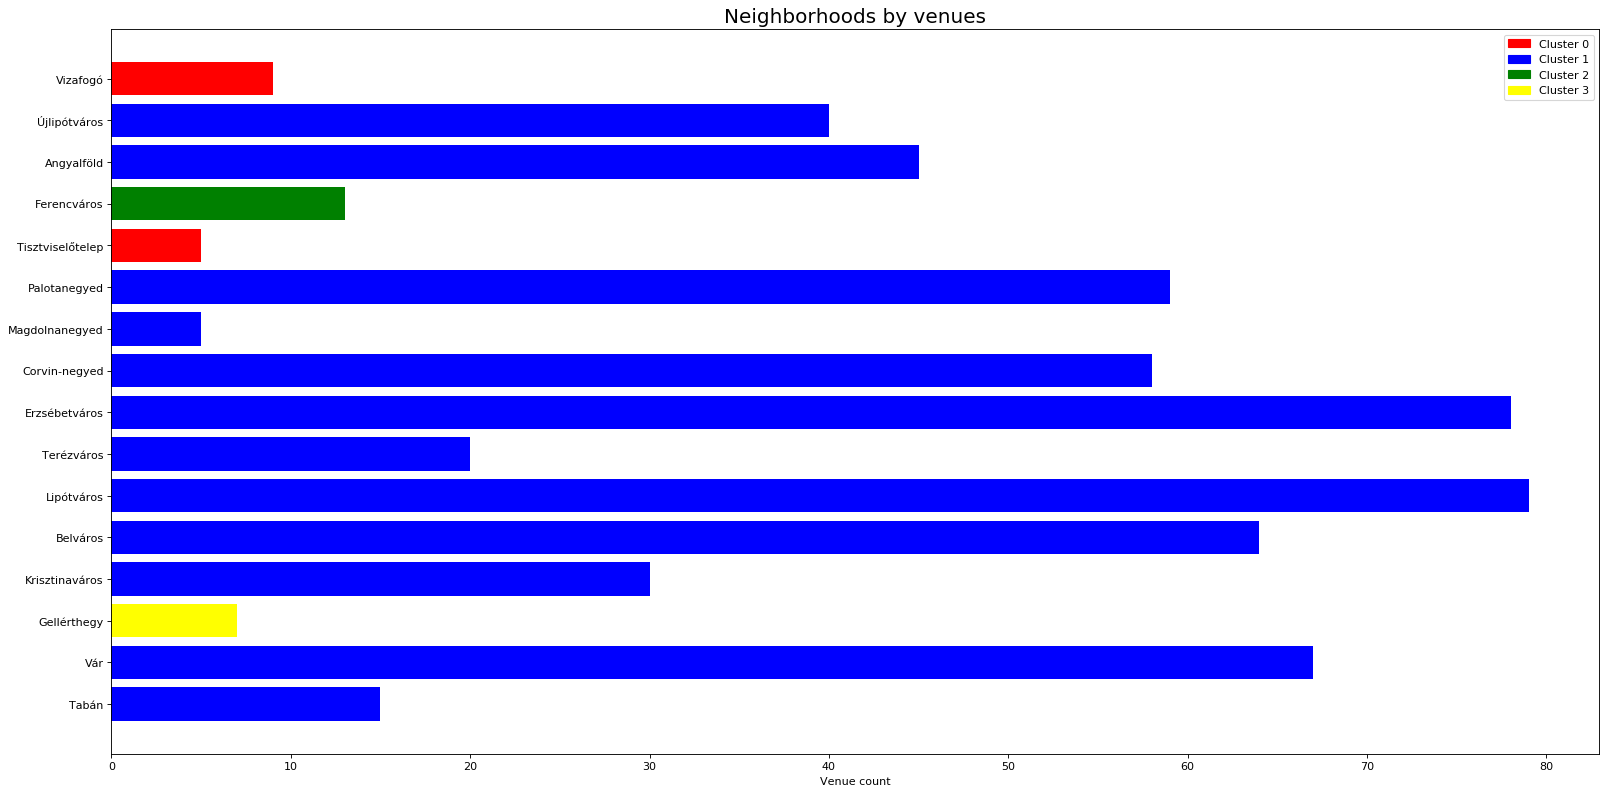

In [34]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Setup figure size
from matplotlib.pyplot import figure
figure(num=None, figsize=(24, 12), dpi=80, facecolor='w', edgecolor='k')

#setup colors list
colors=['red', 'blue', 'green', 'yellow']
cluster_colors = []
for x in full_df['Cluster Labels']:
    cluster_colors.append(colors[x])
    
# Add titles (main and on axis)
plt.xlabel("Venue count")
plt.title("Neighborhoods by venues", fontsize=18)

# Setup values
height = full_df['Venue_count']
bars = (full_df['Neighborhood'])
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height, color=cluster_colors)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

# Legend
red_patch = mpatches.Patch(color='red', label='Cluster 0')
blue_patch = mpatches.Patch(color='blue', label='Cluster 1')
green_patch = mpatches.Patch(color='green', label='Cluster 2')
yellow_patch = mpatches.Patch(color='yellow', label='Cluster 3')
legend = plt.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch])

# Show graphic
plt.show()

We can see that the neighborhoods Lipótváros and Erzsébetváros have the most venues that tourists typically seek.

Now let's make an other bar chart to visualize the average housing prices in each neighborhood. 

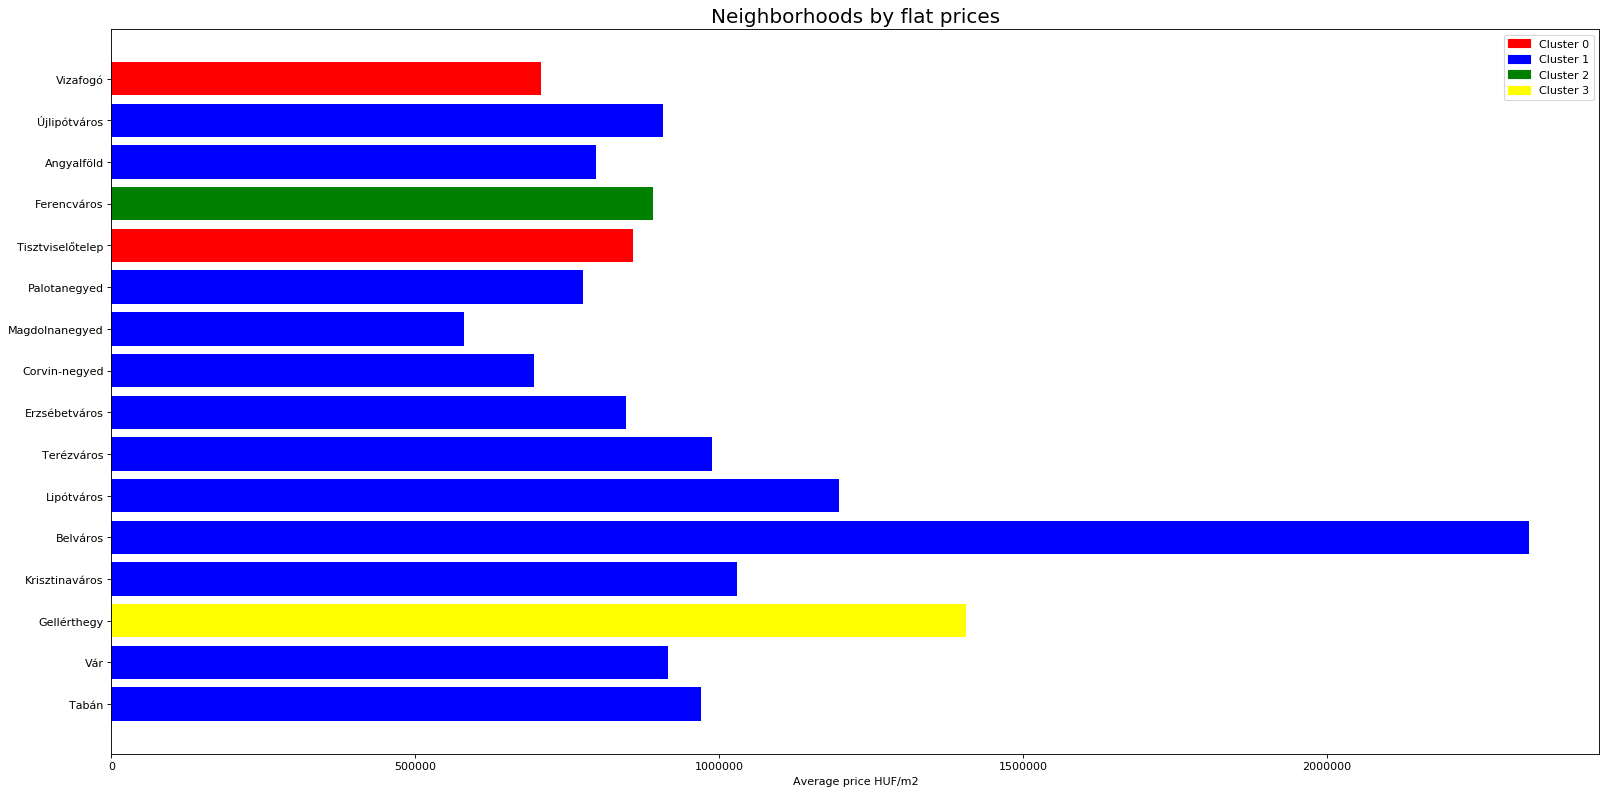

In [32]:
# libraries
import numpy as np
import matplotlib.pyplot as plt

# Setup figure size
from matplotlib.pyplot import figure
figure(num=None, figsize=(24, 12), dpi=80, facecolor='w', edgecolor='k')

#setup colors list
colors=['red', 'blue', 'green', 'yellow']
cluster_colors = []
for x in full_df['Cluster Labels']:
    cluster_colors.append(colors[x])
    
# Add titles (main and on axis)
plt.xlabel("Average price HUF/m2")
plt.title("Neighborhoods by flat prices", fontsize=18)

# Setup values
height = full_df['Average price HUF/m2']
bars = (full_df['Neighborhood'])
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height, color=cluster_colors)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

# Legend
red_patch = mpatches.Patch(color='red', label='Cluster 0')
blue_patch = mpatches.Patch(color='blue', label='Cluster 1')
green_patch = mpatches.Patch(color='green', label='Cluster 2')
yellow_patch = mpatches.Patch(color='yellow', label='Cluster 3')
legend = plt.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch])

# Show graphic
plt.show()

We can see that there are huge differences between the housing prices. The neighborhood Belváros is by far the most expensive, this is the city centre where there are very few flats and most of them are luxury penthouses. The cheapest one is Magdolnanegyed, but we have seen that this is more of a residential neighborhood with very few interesting venues.  
It would be useful to see both the venue counts and the housing prices together to be able to choose the neighborhoods that are ideal in both aspects. We can do that with a bubble chart, where the x axis is the number of venues, the y axis is the average housing price, and the color of the bubbles represent the cluster the neighborhood belongs to.

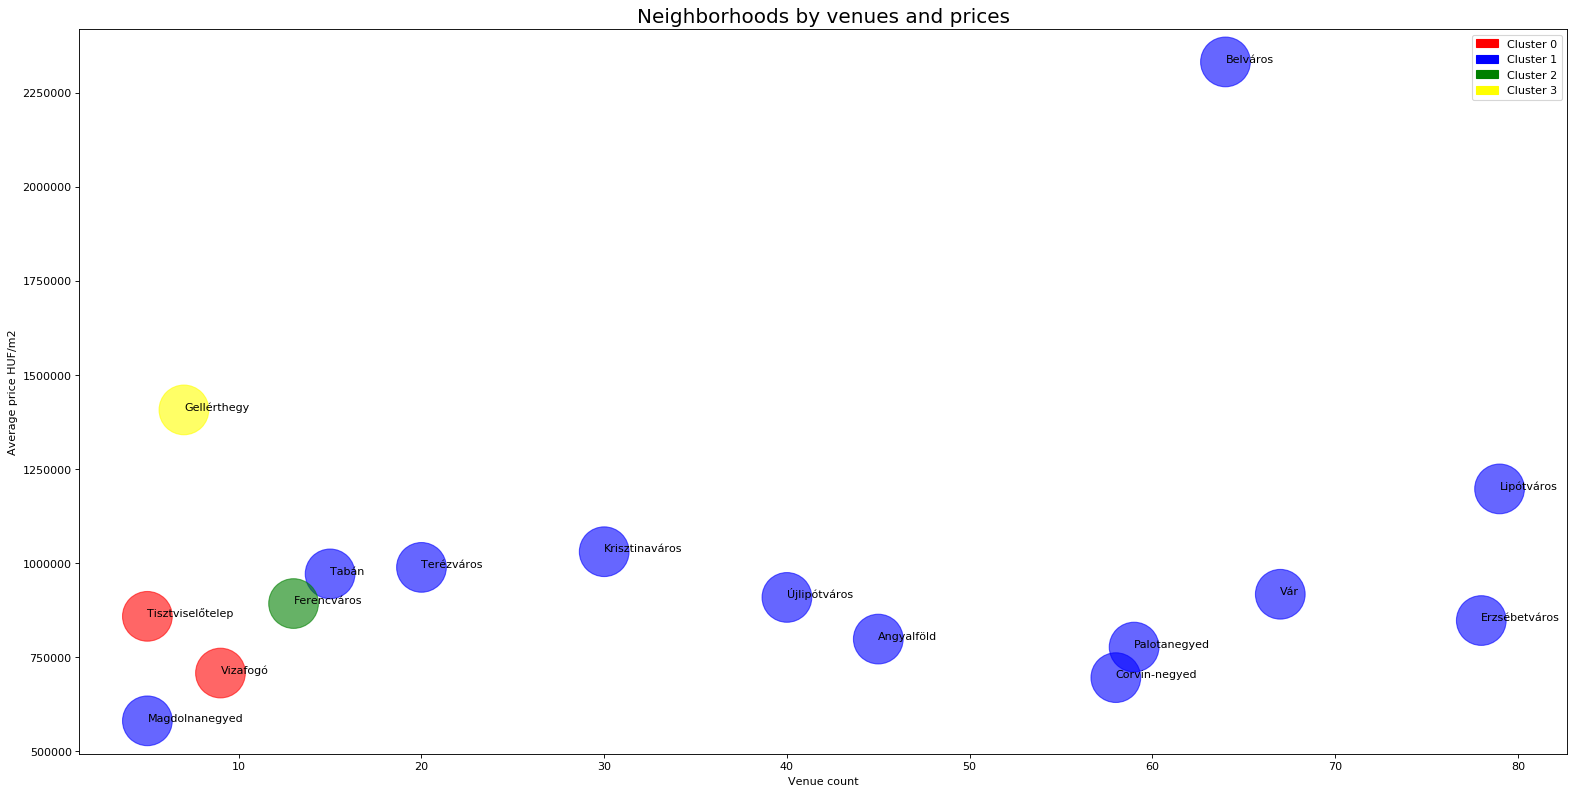

In [33]:
# libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns

#setup colors list
colors=['red', 'blue', 'green', 'yellow']
cluster_colors = []
for x in full_df['Cluster Labels']:
    cluster_colors.append(colors[x])
    
# Setup figure size
from matplotlib.pyplot import figure
figure(num=None, figsize=(24, 12), dpi=80, facecolor='w', edgecolor='k')

# setup scatter
plt.scatter(x=full_df['Venue_count'], 
            y=full_df['Average price HUF/m2'],
            s=2000, 
            c=cluster_colors, 
            alpha=0.6)
 
# Add titles (main and on axis)
plt.xlabel("Venue count")
plt.ylabel("Average price HUF/m2")
plt.title("Neighborhoods by venues and prices", fontsize=18)

# Bubble labels
x, y = full_df['Venue_count'], full_df['Average price HUF/m2']
for i, txt in enumerate(full_df['Neighborhood']):
    plt.annotate(txt, (x[i], y[i]))

# Legend
red_patch = mpatches.Patch(color='red', label='Cluster 0')
blue_patch = mpatches.Patch(color='blue', label='Cluster 1')
green_patch = mpatches.Patch(color='green', label='Cluster 2')
yellow_patch = mpatches.Patch(color='yellow', label='Cluster 3')
legend = plt.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch])

Now we see which neighborhoods are strong in both dimensions. We need those neighborhoods where there are a lot of interesting venues, but the housing prices are quite low - these are located in the lower right corner of the chart.  

## Conclusion

We can finally determine which neighborhoods are the best locations for Airbnb flats and announce the winners of the battle of neighborhoods: Erzsébetváros and Lipótváros.

This result seems correct, as this is the area that is referred to as the "Party District" by locals. With its countless bars, cafés and restaurants, it is the most popular spot for young people.

![alt text](https://szimpla.hu/uploads/content/189/kepek/o_sz8.png "Erzsébetváros")

![alt text](http://www.budnight.hu/wp-content/uploads/2015/05/03_zrinyi_utca.jpeg "Lipótváros")

## References

Colliers (2018) AIRBNB IN EUROPE -BUDAPEST, https://www.colliers.com/-/media/files/emea/emea/research/hotels/airbnb_budapest_2018_v6.pdf?la=en-gb;  

Ingatlannet.hu (2019) Real estate statistics, https://www.ingatlannet.hu/statisztika/Budapest;  

Jancsik, András and Michalkó, Gábor and Csernyik, Márta (2018) Megosztás megosztottság nélkül – az Airbnb és a budapesti szálláshelypiac átalakulása. KÖZGAZDASÁGI SZEMLE, 65 (3). pp. 259-286. ISSN 0023-4346., http://real.mtak.hu/77930/;  

Wikipedia (2019) List of neighborhoods in Budapest, https://hu.wikipedia.org/wiki/Budapest_városrészeinek_listája  


Cover photo from National Geographic, https://www.nationalgeographic.com/content/dam/travel/Guide-Pages/europe/budapest-travel.adapt.1900.1.jpg